After reading chapter 2 of book I reached the Try it out section of the book. I am to pick any dataset I want and use it to practice the data science cycle taught by this chapter.
I chose kaggle titanic dataset. The goal is to "use machine learning to create a model that predicts which passengers survived the Titanic shipwreck."

In [1]:
import kaggle
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import numpy as np

In [2]:
def load_titanic_train_test_set():
    if not Path("datasets/titanic").is_dir():
        Path("datasets").mkdir(exist_ok=True)
        kaggle.api.authenticate()
        kaggle.api.competition_download_files("titanic", path="./datasets", force=False, quiet=True)
    
        with ZipFile("datasets/titanic.zip", 'r') as titanic_zip:
            titanic_zip.extractall("datasets/titanic")
    
    return pd.read_csv("datasets/titanic/train.csv", index_col="PassengerId"), pd.read_csv("datasets/titanic/test.csv",index_col="PassengerId")


In [3]:
train, test = load_titanic_train_test_set()

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (891, 11)
Test shape: (418, 10)


In [4]:
# saving a copy before anything
train_copy = train.copy()
test_copy = test.copy()

## Explore Data

In [5]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


    Convert sex to a binary type column
    Age has missing values
    cabin has a lot of missing values, see correlation with survived
    find out what is relevant in name and ticket (if they are relevant)
    

In [7]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# inspect non-null cabin values
train["Cabin"].value_counts() # when Pclass == 1

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

Assuming the letter of the Cabin number represents the deck or section of boat where the cabin was located followed by the room number. So I am assuming the number did not matter, only the deck of the Cabin. Also, since there is a lot of missing values, I am going to impute the most frequent decks for each Pclass. If this hurts more than helps I will drop this column

In [9]:
# is the training set unbalanced?
pd.concat([train["Survived"].value_counts(), (train["Survived"].value_counts() / train["Survived"].count()).round(2)], axis=1) # a little

,count,count
Survived,,
0,549,0.62
1,342,0.38


## Words correlation (names and ticket)

Word clouds look like a good way to see if there is any pattern between survivors and their names and non-survivors and their names

In [10]:
# get indexes of survivors and nonsurvivors
indexes_survived = train["Survived"] == 1
indexes_not_survived = train["Survived"] == 0

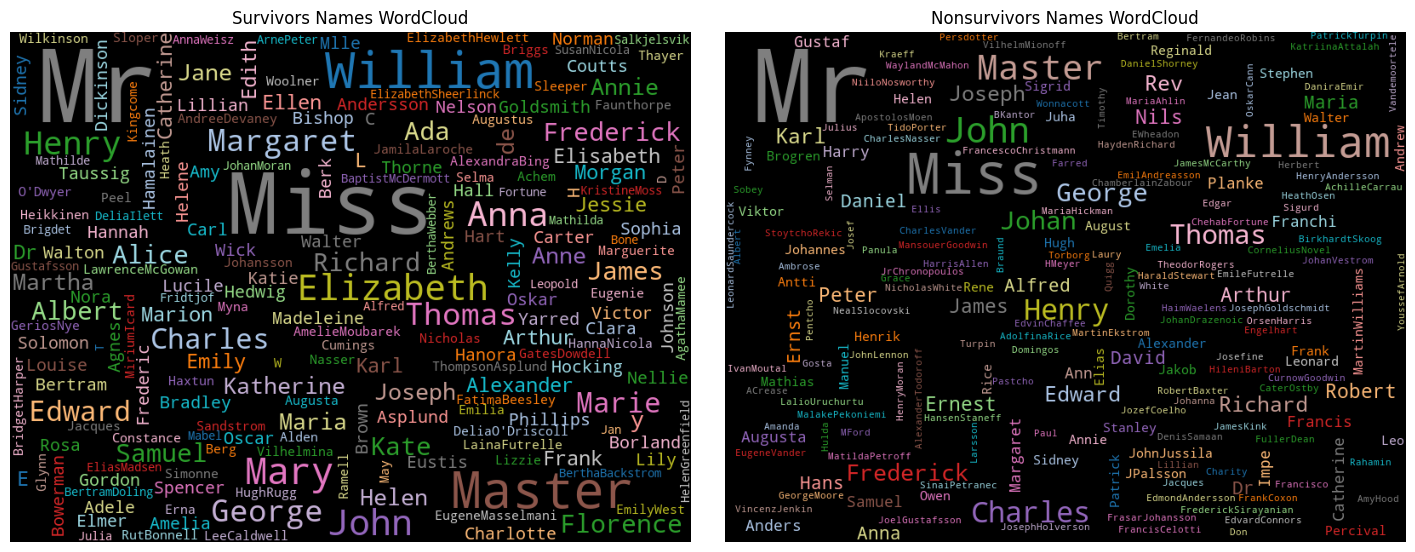

In [11]:
# see wordclouds of both survivors names and nonsurvivors names
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1,2,figsize=(18,8))

all_survivors_names = "".join([ name for name in train[indexes_survived]["Name"]])
word_cloud = WordCloud(width=800, height=600, random_state=42, max_font_size=120, colormap="tab20").generate(all_survivors_names)

all_non_survivors_names = "".join([ name for name in train[indexes_not_survived]["Name"]])
word_cloud2 = WordCloud(width=800, height=600, random_state=42, max_font_size=120, colormap="tab20").generate(all_non_survivors_names)

axes[0].imshow(word_cloud)
axes[1].imshow(word_cloud2)
axes[0].axis("off")
axes[1].axis("off")
axes[0].set_title("Survivors Names WordCloud")
axes[1].set_title("Nonsurvivors Names WordCloud")
plt.subplots_adjust(wspace=0.05)
plt.show()

I was hoping that some prefixes would be correlated to chance of survival but, after a lot of inspection, names do not seem to have any correlation at all. Name column will be dropped.

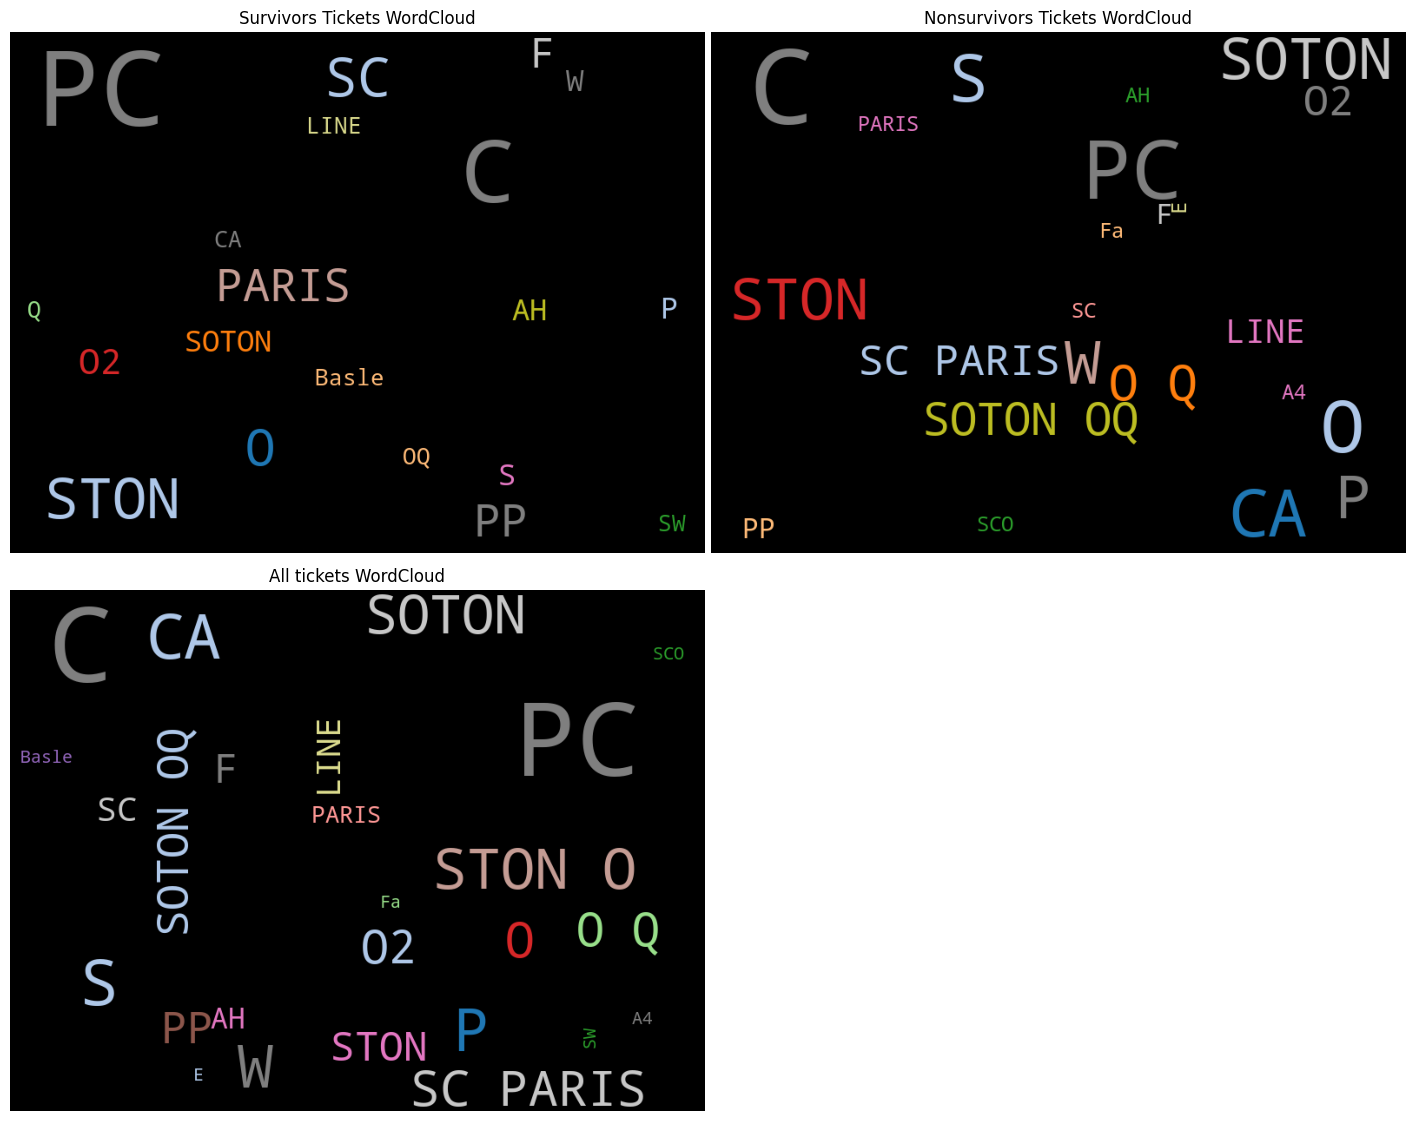

In [12]:
# see wordclouds of both survivors tickets and nonsurvivors tickets
fig, axes = plt.subplots(2,2,figsize=(18,14.5))

all_survivors_tickets = "".join([ticket + " " for ticket in train[indexes_survived]["Ticket"]])
word_cloud3 = WordCloud(width=800, height=600, random_state=42, max_font_size=120, colormap="tab20").generate(all_survivors_tickets)

all_non_survivors_tickets = "".join([ticket + " " for ticket in train[indexes_not_survived]["Ticket"]])
word_cloud4 = WordCloud(width=800, height=600, random_state=42, max_font_size=120, colormap="tab20").generate(all_non_survivors_tickets)

all_tickets = "".join([ticket + " " for ticket in train["Ticket"]])
word_cloud5 = WordCloud(width=800, height=600, random_state=42, max_font_size=120, colormap="tab20").generate(all_tickets)

axes[0][0].imshow(word_cloud3)
axes[0][1].imshow(word_cloud4)
axes[1][0].imshow(word_cloud5)
axes[0][0].axis("off")
axes[0][1].axis("off")
axes[1][0].axis("off")
axes[1][1].axis("off")
axes[0][0].set_title("Survivors Tickets WordCloud")
axes[0][1].set_title("Nonsurvivors Tickets WordCloud")
axes[1][0].set_title("All tickets WordCloud")
plt.subplots_adjust(wspace=0.009, hspace=0.0001)
plt.show()

There does not seem to have any correlation between the ticket type and the survival rate. I read somewhere some tickets are repeated but for some reason the the Wordcloud is not showing any number only the ticket type. So I am going to ignore the ticket feature.

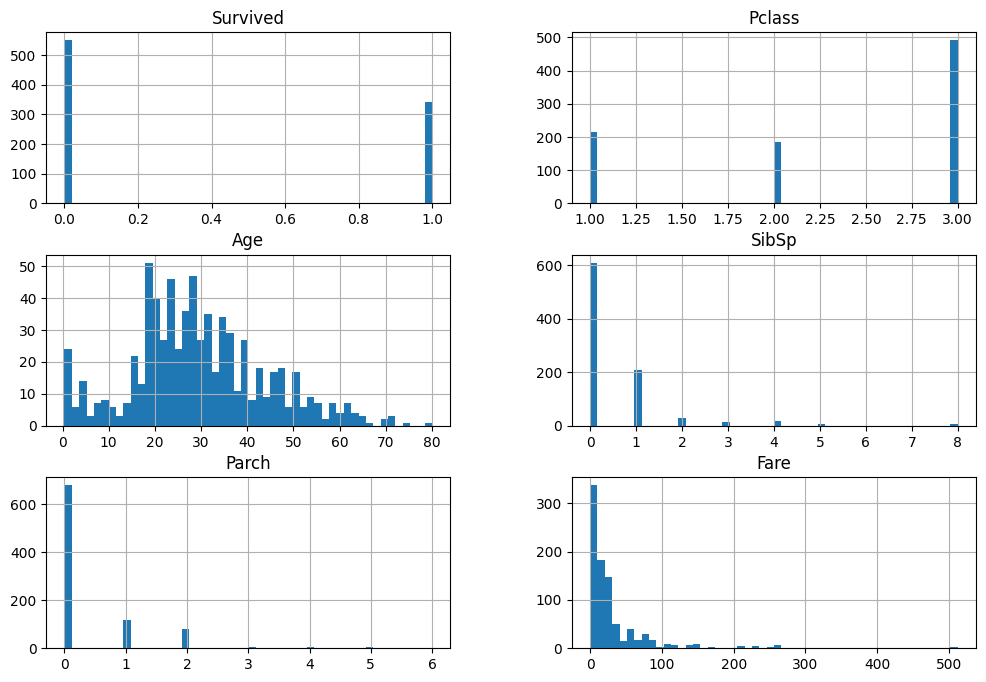

In [13]:
# visualizing numerical data
train.hist(bins=50, figsize=(12,8))

plt.show()

## Creating, dropping, changing columns, and seeing correlation with label

In [14]:
# dropping ticket and name
train.drop(["Name","Ticket"],axis=1,inplace=True)
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C


In [15]:
# adding a new column "Family" which is SibSp + Parch
train["Family"] = train["SibSp"] + train["Parch"]

train[["SibSp","Parch", "Family"]].head(10)

,SibSp,Parch,Family
PassengerId,,,
1,1,0,1
2,1,0,1
3,0,0,0
4,1,0,1
5,0,0,0
6,0,0,0
7,0,0,0
8,3,1,4
9,0,2,2


In [16]:
# Using one hot encoding for cabin number using only the deck letter
train["Cabin"] = train["Cabin"].apply(lambda x: x if pd.isna(x) else x[0])
print(train["Cabin"].unique()) # see one-hot columns and nan

train = pd.concat([train,pd.get_dummies(train["Cabin"].dropna(), prefix="Deck_")], axis=1, ) # add one-hot features
train.drop("Cabin",axis=1,inplace=True)
train.head()

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__T
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,female,38.0,1,0,71.2833,C,1,False,False,True,False,False,False,False,False
3,1,3,female,26.0,0,0,7.9250,S,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,female,35.0,1,0,53.1000,S,1,False,False,True,False,False,False,False,False
5,0,3,male,35.0,0,0,8.0500,S,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# make a binary type version of sex
train["Sex"] = train["Sex"].apply(lambda sex: 1 if sex == "male" else 0)
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__T
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,0,38.0,1,0,71.2833,C,1,False,False,True,False,False,False,False,False


In [18]:
# make one-hot representaion of embarked
train = pd.concat([train,pd.get_dummies(train["Embarked"].dropna(), prefix="Embarked_")], axis=1)
train.drop("Embarked", axis=1,inplace=True)
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__T,Embarked__C,Embarked__Q,Embarked__S
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
2,1,1,0,38.0,1,0,71.2833,1,False,False,True,False,False,False,False,False,True,False,False


In [19]:
# make one-hot representaion of Pclass
train = pd.concat([train,pd.get_dummies(train["Pclass"].dropna(), prefix="Pclass_")], axis=1)
train.drop("Pclass", axis=1,inplace=True)
train.head(2)

,Survived,Sex,Age,SibSp,Parch,Fare,Family,Deck__A,Deck__B,Deck__C,...,Deck__E,Deck__F,Deck__G,Deck__T,Embarked__C,Embarked__Q,Embarked__S,Pclass__1,Pclass__2,Pclass__3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,22.0,1,0,7.2500,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,True,False,False,True
2,1,0,38.0,1,0,71.2833,1,False,False,True,...,False,False,False,False,True,False,False,True,False,False


In [20]:
# see correlation
train.corr()["Survived"].sort_values(ascending=False).round(3)

Survived       1.000
Pclass__1      0.286
Fare           0.257
Embarked__C    0.170
Pclass__2      0.093
Deck__B        0.091
Deck__D        0.085
Parch          0.082
Deck__E        0.076
Family         0.017
Embarked__Q    0.005
Deck__F       -0.028
SibSp         -0.035
Deck__G       -0.050
Age           -0.077
Deck__T       -0.099
Deck__C       -0.099
Deck__A       -0.120
Embarked__S   -0.152
Pclass__3     -0.322
Sex           -0.543
Name: Survived, dtype: float64

## Fixing Fare heavy tail. Transforming to its square root

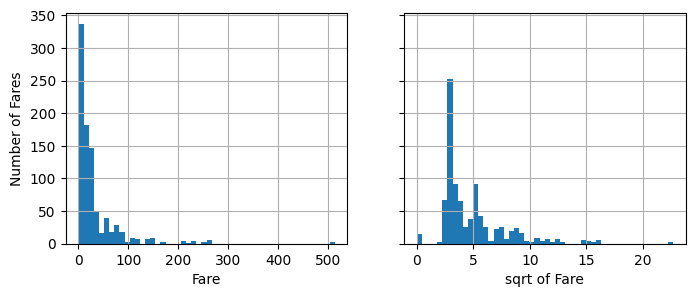

In [21]:
# see histogram of sqrt of Fare and Fare
fig, axs = plt.subplots(1,2,figsize=(8,3), sharey=True)
train["Fare"].hist(ax=axs[0], bins=50)
train["Fare"].apply(np.sqrt).hist(ax=axs[1],bins=50)

axs[0].set_xlabel("Fare")
axs[1].set_xlabel("sqrt of Fare")
axs[0].set_ylabel("Number of Fares")
plt.show() # This seems to improve the heavy tail

# Preprocessing

## Transform functions

In [22]:
train = train_copy.copy() # resetting dataframe
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### One-hot encoding representations 

In [23]:
# creating a transformer function to convert cabins to their respectives decks or NA if value is Null and creating one-hot represenations
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

def get_cabin(X):
    return X.apply(lambda x: "NA" if pd.isna(x) else x[0])

deck_pipeline = Pipeline([("get_deck",FunctionTransformer(pd.DataFrame.apply,feature_names_out="one-to-one",kw_args=dict(func=get_cabin))), ("OneHot", OneHotEncoder(sparse_output=False,
                                                                                                                                             handle_unknown="ignore"))])
print(deck_pipeline.fit_transform(train[["Cabin"]]).shape)
print(deck_pipeline.get_feature_names_out())

(891, 9)
['Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D' 'Cabin_E' 'Cabin_F' 'Cabin_G'
 'Cabin_NA' 'Cabin_T']


In [24]:
# since OneHotEncoder fucntion would create 2 columns for sex feature, I made a simple function to convert to binary and keeping a single column
def sexToBinary(X):
    return X.apply(lambda x: 1 if x == "male" else 0)
    
sex_pipeline = Pipeline([("to_binary",FunctionTransformer(pd.DataFrame.apply, feature_names_out="one-to-one", kw_args=dict(func=sexToBinary)))])
print(sex_pipeline.fit_transform(train[["Sex"]]).head())
print(sex_pipeline.get_feature_names_out())

             Sex
PassengerId     
1              1
2              0
3              0
4              0
5              1
['Sex']


In [25]:
# embarked has 2 missing values so I am imputing the most frequent value and then creating their one-hot representation
from sklearn.impute import SimpleImputer

embarked_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("OneHot", OneHotEncoder(sparse_output=False))])
print(embarked_pipeline.fit_transform(train[["Embarked"]]).shape)
print(embarked_pipeline.get_feature_names_out())

(891, 3)
['Embarked_C' 'Embarked_Q' 'Embarked_S']


In [26]:
# creating one hot encoding representations for pclass
pclass_pipeline = Pipeline([("imputer",SimpleImputer(strategy="most_frequent")),("OneHot", OneHotEncoder(sparse_output=False))])
print(pclass_pipeline.fit_transform(train[["Pclass"]]))
print(pclass_pipeline.get_feature_names_out())

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
['Pclass_1' 'Pclass_2' 'Pclass_3']


### Transforming Fare 

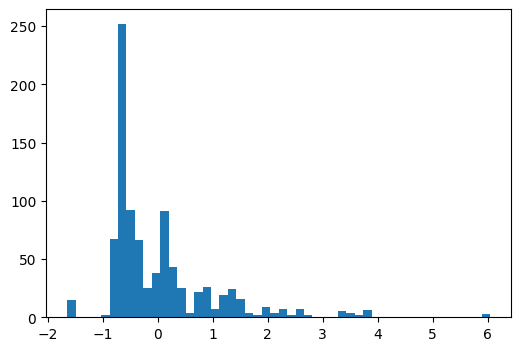

In [27]:
# taking the square root of fare and scaling it for training
from sklearn.preprocessing import StandardScaler
fare_pipeline = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("sqrt", FunctionTransformer(np.sqrt, feature_names_out="one-to-one")), ("scale",StandardScaler())])
plt.figure(figsize=(6,4))
plt.hist(fare_pipeline.fit_transform(train[["Fare"]]), bins=50, label="Fare")
plt.show()

### Age imputing and scaling

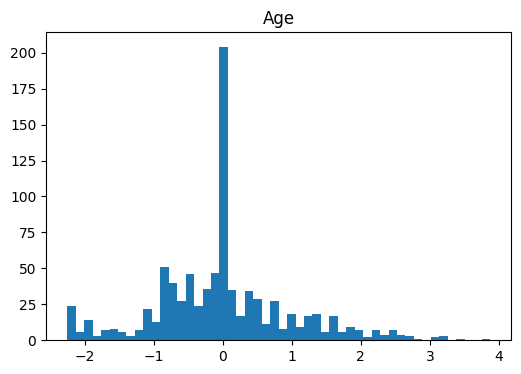

In [28]:
age_pipeline = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaling", StandardScaler())])

# plotting histogram
plt.figure(figsize=(6,4))
plt.hist(age_pipeline.fit_transform(train[["Age"]]), bins=50, label="Age")
plt.title("Age")
plt.show()

### Scaling real-valued features

['Family']


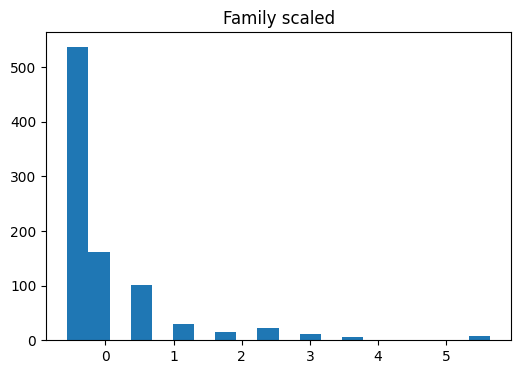

In [31]:
# creating family feature and scaling it using make_pipeline and plotting its histogram
from sklearn.pipeline import make_pipeline

def create_column_family(X):
    return X[:,[0]] + X[:,[1]]

def get_family_name(function_transformer, feature_names_in):
    return ["Family"]

family_pipeline = make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(create_column_family, feature_names_out=get_family_name), StandardScaler())

plt.figure(figsize=(6,4))
plt.hist(family_pipeline.fit_transform(train[["SibSp","Parch"]]), bins=20)
print(family_pipeline.get_feature_names_out())
plt.title("Family scaled")
plt.show()

['SibSp' 'Parch']


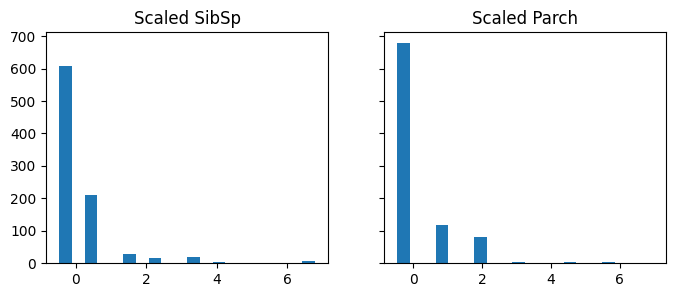

In [32]:
# scaling numerical features except Age and plotting their histograms
num_columns = ["SibSp","Parch"]
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),("scaling", StandardScaler())])
arr = num_pipeline.fit_transform(train[num_columns])
print(num_pipeline.get_feature_names_out())
fig, axis = plt.subplots(1,2, figsize=(8,3),sharey=True)
axis[0].hist(arr[:,0], bins=20)
axis[0].set_title("Scaled {}".format(num_columns[0]))
axis[1].hist(arr[:,1], bins=20)
axis[1].set_title("Scaled {}".format(num_columns[1]))
plt.show()

## Preprocessing pipeline

In [33]:
from sklearn.compose import make_column_transformer

preprocessing = make_column_transformer((deck_pipeline, ["Cabin"]), (sex_pipeline, ["Sex"]), 
(embarked_pipeline,["Embarked"]),(pclass_pipeline,["Pclass"]), (fare_pipeline, ["Fare"]),
(age_pipeline, ["Age"]), (family_pipeline, ["SibSp", "Parch"]), (num_pipeline, ["SibSp", "Parch"]))

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('get_deck',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function DataFrame.apply at 0x000001C9F88FCE00>,
                                                                      kw_args={'func': <function get_cabin at 0x000001C9FDD61120>})),
                                                 ('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Cabin']),
                                ('pipeline-2',
                                 Pipeline(steps=[('...
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function get_family_name at 0x000001C9962C1C60>,
                                                                      func=<function create_column_family at 0x000001C9962C0360>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['SibSp', 'Parch']),
                                ('pipeline-8',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['SibSp', 'Parch'])])

In [34]:
preprocessing.fit_transform(train).shape

(891, 21)

In [35]:
preprocessing.fit_transform(train)

array([[ 0.        ,  0.        ,  0.        , ...,  0.05915988,
         0.43279337, -0.47367361],
       [ 0.        ,  0.        ,  1.        , ...,  0.05915988,
         0.43279337, -0.47367361],
       [ 0.        ,  0.        ,  0.        , ..., -0.56097483,
        -0.4745452 , -0.47367361],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.29942929,
         0.43279337,  2.00893337],
       [ 0.        ,  0.        ,  1.        , ..., -0.56097483,
        -0.4745452 , -0.47367361],
       [ 0.        ,  0.        ,  0.        , ..., -0.56097483,
        -0.4745452 , -0.47367361]])

In [36]:
preprocessing.get_feature_names_out()

array(['pipeline-1__Cabin_A', 'pipeline-1__Cabin_B',
       'pipeline-1__Cabin_C', 'pipeline-1__Cabin_D',
       'pipeline-1__Cabin_E', 'pipeline-1__Cabin_F',
       'pipeline-1__Cabin_G', 'pipeline-1__Cabin_NA',
       'pipeline-1__Cabin_T', 'pipeline-2__Sex', 'pipeline-3__Embarked_C',
       'pipeline-3__Embarked_Q', 'pipeline-3__Embarked_S',
       'pipeline-4__Pclass_1', 'pipeline-4__Pclass_2',
       'pipeline-4__Pclass_3', 'pipeline-5__Fare', 'pipeline-6__Age',
       'pipeline-7__Family', 'pipeline-8__SibSp', 'pipeline-8__Parch'],
      dtype=object)

# Select and Train a Model

In this section, I am going to asses 4 ML algorithms (logistic regression, svm, knn, random forest) and pick the best one for fine-tuning.

In [37]:
# splitting the label from the features
y_train = train["Survived"]
x_train = train.drop("Survived", axis=1)
print(y_train.head())
print(x_train.head())

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64
             Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0

### KNN

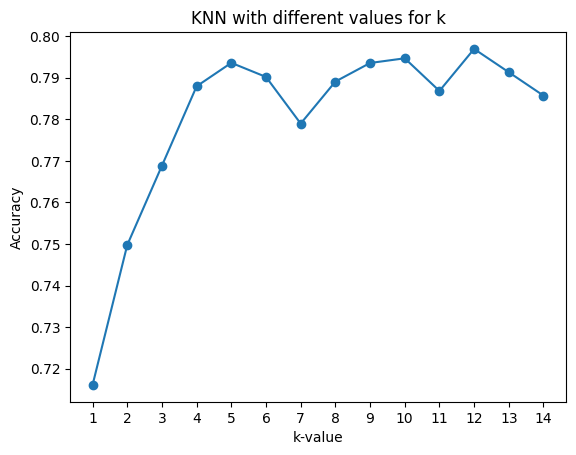

Max reached accuracy: 0.796899127487289


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error

# testing k from 1 to 14
n = 15
knn_means = []
for k in range(1,n):
    knn = make_pipeline(preprocessing, KNeighborsClassifier(k))
    mean = pd.Series(cross_val_score(knn, x_train, y_train, scoring="accuracy", cv=5)).mean()
    knn_means.append(mean)

# plotting
plt.plot(np.arange(1,n), knn_means, marker='o')
plt.xticks(np.arange(1,n))
plt.title("KNN with different values for k")
plt.ylabel("Accuracy")
plt.xlabel("k-value")
plt.show()
print("Max reached accuracy:",max(knn_means))

### SVM

In [39]:
from sklearn.svm import SVC

# simple SVM with C=1 and kernel=RBF
svm_rbf = make_pipeline(preprocessing, SVC())
scores = cross_val_score(svm_rbf,x_train,y_train,scoring="accuracy", cv=5)

# Statistics of the scores
pd.Series(scores).describe()

count    5.000000
mean     0.820432
std      0.018981
min      0.808989
25%      0.808989
50%      0.814607
75%      0.815642
max      0.853933
dtype: float64

In [40]:
# SVM with C=1 and kernel=linear
svm_linear = make_pipeline(preprocessing, SVC(kernel="linear"))
scores = cross_val_score(svm_linear,x_train,y_train,scoring="accuracy", cv=5)

# Statistics of the scores
pd.Series(scores).describe()

count    5.000000
mean     0.786755
std      0.017324
min      0.758427
25%      0.786517
50%      0.787709
75%      0.797753
max      0.803371
dtype: float64

### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

# trying logistic regression with L2 regularization, C=1.0, and solver is lbfgs
logReg_l2 = make_pipeline(preprocessing, LogisticRegression())

scores = cross_val_score(logReg_l2,x_train,y_train,scoring="accuracy", cv=5)

pd.Series(scores).describe()

count    5.000000
mean     0.799121
std      0.013601
min      0.782123
25%      0.797753
50%      0.797753
75%      0.797753
max      0.820225
dtype: float64

In [42]:
## trying logistic regression with L1 regularization, C=1.0, and solver is lbfgs
logReg_liblinear_l2 = make_pipeline(preprocessing, LogisticRegression(solver="liblinear"))

scores = cross_val_score(logReg_liblinear_l2,x_train,y_train,scoring="accuracy", cv=5)

pd.Series(scores).describe()

count    5.000000
mean     0.799115
std      0.012531
min      0.787709
25%      0.792135
50%      0.797753
75%      0.797753
max      0.820225
dtype: float64

In [43]:
# trying logistic regression with L1 regularization, C=1.0, and solver is lbfgs
logReg_liblinear_l1 = make_pipeline(preprocessing, LogisticRegression(solver="liblinear",penalty="l1"))

scores = cross_val_score(logReg_liblinear_l1,x_train,y_train,scoring="accuracy", cv=5)

pd.Series(scores).describe()

count    5.000000
mean     0.795763
std      0.018016
min      0.770950
25%      0.792135
50%      0.792135
75%      0.803371
max      0.820225
dtype: float64

### Random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
# random forest with 100 estimators, gini as criterion, and max features per estimator is sqrt of max features
rfc = Pipeline([("preprocessing",preprocessing), ("rfc",RandomForestClassifier(random_state=42))])

rfc

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('get_deck',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function DataFrame.apply at 0x000001C9F88FCE00>,
                                                                                       kw_args={'func': <function get_cabin at 0x000001C9FDD61120>})),
                                                                  ('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Cabin'])...
                                                                   FunctionTransformer(feature_names_out=<function get_family_name at 0x000001C9962C1C60>,
                                                                                       func=<function create_column_family at 0x000001C9962C0360>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('pipeline-8',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch'])])),
                ('rfc', RandomForestClassifier(random_state=42))])

In [45]:
scores = cross_val_score(rfc,x_train,y_train,scoring="accuracy", cv=5)

pd.Series(scores).describe()

count    5.000000
mean     0.808116
std      0.037292
min      0.775281
25%      0.776536
50%      0.792135
75%      0.848315
max      0.848315
dtype: float64

In [46]:
# seeing importance of features using random forests
rfc.fit(x_train,y_train)

sorted(zip(rfc["rfc"].feature_importances_, rfc["preprocessing"].get_feature_names_out()),reverse=True)

[(0.24573545410599051, 'pipeline-6__Age'),
 (0.23671537500647777, 'pipeline-2__Sex'),
 (0.2225203518159467, 'pipeline-5__Fare'),
 (0.047293046641407974, 'pipeline-7__Family'),
 (0.04128209794002855, 'pipeline-4__Pclass_3'),
 (0.035019104452730515, 'pipeline-1__Cabin_NA'),
 (0.03219390278665144, 'pipeline-8__SibSp'),
 (0.02654583224341099, 'pipeline-8__Parch'),
 (0.021425467886629468, 'pipeline-4__Pclass_1'),
 (0.01633718624498811, 'pipeline-3__Embarked_S'),
 (0.016195589553920375, 'pipeline-4__Pclass_2'),
 (0.014850594914607702, 'pipeline-3__Embarked_C'),
 (0.00963004799069982, 'pipeline-1__Cabin_E'),
 (0.008103401951158499, 'pipeline-3__Embarked_Q'),
 (0.006610695811981149, 'pipeline-1__Cabin_C'),
 (0.005661581190626225, 'pipeline-1__Cabin_B'),
 (0.005571233650323073, 'pipeline-1__Cabin_D'),
 (0.004117753354999779, 'pipeline-1__Cabin_A'),
 (0.0027480392156726263, 'pipeline-1__Cabin_F'),
 (0.0010384013640408402, 'pipeline-1__Cabin_G'),
 (0.0004048418777078305, 'pipeline-1__Cabin_T')]

### Hyperparameter tuning (SVM and Random Forest)

#### Random Forest

In [47]:
from sklearn.model_selection import GridSearchCV

# parameters to tune
param_grid = {"rfc__criterion":["gini","entropy"],"rfc__max_features":np.arange(3,22,3)}

# grid search with cross validation = 4
grid_search = GridSearchCV(rfc,param_grid, cv=4, scoring="accuracy")

grid_search.fit(x_train,y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('get_deck',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function DataFrame.apply at 0x000001C9F88FCE00>,
                                                                                                              kw_args={'func': <function get_cabin at 0x000001C9FDD61120>})),
                                                                                         ('OneHot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse...
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('pipeline-8',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         ['SibSp',
                                                                          'Parch'])])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_features': array([ 3,  6,  9, 12, 15, 18, 21])},
             scoring='accuracy')

In [48]:
columns = ["param_rfc__criterion","param_rfc__max_features","mean_test_score", "std_test_score", "rank_test_score"]

# results
pd.DataFrame(grid_search.cv_results_)[columns].sort_values("rank_test_score") #Best mean score is 0.814

,param_rfc__criterion,param_rfc__max_features,mean_test_score,std_test_score,rank_test_score
5,gini,18,0.813720,0.037467,1
2,gini,9,0.813714,0.027781,2
13,entropy,21,0.813714,0.024919,2
12,entropy,18,0.813709,0.027076,4
11,entropy,15,0.812593,0.029507,5
4,gini,15,0.812583,0.035720,6
10,entropy,12,0.811462,0.025065,7
3,gini,12,0.811457,0.026081,8
6,gini,21,0.810341,0.031520,9
9,entropy,9,0.809215,0.020070,10


#### SVM

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# svm with rbf kernel
svm_rbf = Pipeline([("preprocessing", preprocessing), ("svm",SVC(random_state=42))])
param_distribs = {"svm__C":randint(low=0,high=100)}
                  
random_search = RandomizedSearchCV(svm_rbf, param_distribs, n_iter=50, cv=4, scoring="accuracy", random_state=42)

random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('get_deck',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function DataFrame.apply at 0x000001C9F88FCE00>,
                                                                                                                    kw_args={'func': <function get_cabin at 0x000001C9FDD61120>})),
                                                                                               ('OneHot',
                                                                                                OneHotEncoder(handle_unknown='ignore',...
                                                                                                StandardScaler())]),
                                                                               ['SibSp',
                                                                                'Parch']),
                                                                              ('pipeline-8',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaling',
                                                                                                StandardScaler())]),
                                                                               ['SibSp',
                                                                                'Parch'])])),
                                             ('svm', SVC(random_state=42))]),
                   n_iter=50,
                   param_distributions={'svm__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C99660C4D0>},
                   random_state=42, scoring='accuracy')

In [50]:
columns = ["param_svm__C","mean_test_score", "std_test_score", "rank_test_score"]

pd.DataFrame(random_search.cv_results_)[columns].sort_values("rank_test_score").head(10) #Best mean score is 0.827

,param_svm__C,mean_test_score,std_test_score,rank_test_score
44,2,0.827183,0.015797,1
13,2,0.827183,0.015797,1
20,1,0.822693,0.017881,3
16,1,0.822693,0.017881,3
46,6,0.818204,0.014798,5
2,14,0.810346,0.016676,6
36,14,0.810346,0.016676,6
47,20,0.805862,0.021149,8
5,20,0.805862,0.021149,8
23,20,0.805862,0.021149,8


## Making prediction on the test set

In [51]:
# Best model is SVM with kernel=rbf and C=2

final_model = Pipeline([("preprocessing", preprocessing), ("svm",SVC(random_state=42, C=2))])

final_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('get_deck',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function DataFrame.apply at 0x000001C9F88FCE00>,
                                                                                       kw_args={'func': <function get_cabin at 0x000001C9FDD61120>})),
                                                                  ('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Cabin'])...
                                                                   FunctionTransformer(feature_names_out=<function get_family_name at 0x000001C9962C1C60>,
                                                                                       func=<function create_column_family at 0x000001C9962C0360>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('pipeline-8',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch'])])),
                ('svm', SVC(C=2, random_state=42))])

In [58]:
df_predictions = pd.DataFrame(final_model.predict(test), index=test.index, columns=["Survived"])

df_predictions.head(7)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,1


In [59]:
df_predictions.to_csv("svm_predictions.csv")

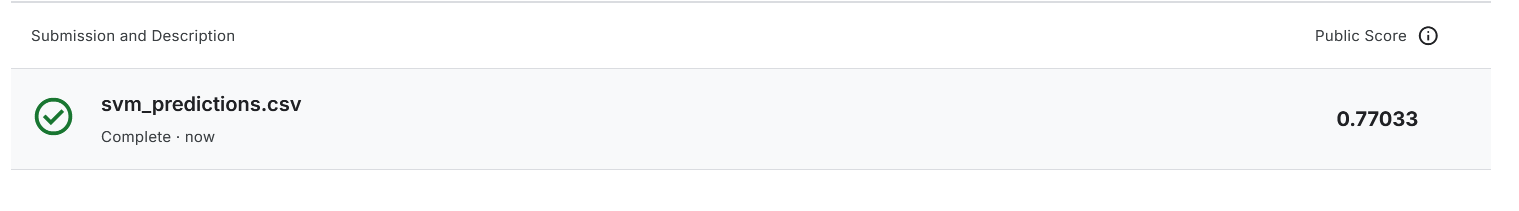